In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add


class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": ""}, config)

{'foo': 'b', 'bar': ['a', 'b']}

In [6]:
type(graph.get_state(config))
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08cd7d-8c9c-6c70-8002-b2afe6db2e7f'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-08T17:18:33.144629+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08cd7d-8c9b-6432-8001-1ab318a84144'}}, tasks=(), interrupts=())

In [12]:
list(graph.get_state_history(config))


[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08cd7d-8c9c-6c70-8002-b2afe6db2e7f'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-08T17:18:33.144629+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08cd7d-8c9b-6432-8001-1ab318a84144'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08cd7d-8c9b-6432-8001-1ab318a84144'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-08T17:18:33.144008+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08cd7d-8c99-65a3-8000-279b230cf018'}}, tasks=(PregelTask(id='a774fbb8-34fa-2949-0295-370bb5e8f1c2', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts

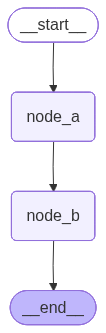

In [13]:
workflow.compile()

In [3]:
from langgraph.types import StateSnapshot
StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ca72-60e7-67b4-8002-5fb118d59ff8'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-08T11:29:57.439468+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ca72-60e4-61fd-8001-7b18a56791ce'}}, tasks=(), interrupts=())

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ca72-60e7-67b4-8002-5fb118d59ff8'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-08T11:29:57.439468+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ca72-60e4-61fd-8001-7b18a56791ce'}}, tasks=(), interrupts=())

In [14]:
import json
from typing import Any, Dict

def snapshot_to_db_record(snapshot) -> Dict[str, Any]:
    checkpoint_id = snapshot.config.get("configurable", {}).get("checkpoint_id")
    thread_id = snapshot.config.get("configurable", {}).get("thread_id")
    return {
        "checkpoint_id": checkpoint_id,
        "thread_id": thread_id,
        "values": json.dumps(snapshot.values),
        "next": json.dumps(snapshot.next),
        "config": json.dumps(snapshot.config),
        "metadata": json.dumps(snapshot.metadata),
        "created_at": snapshot.created_at,
        "parent_config": json.dumps(snapshot.parent_config),
        "tasks": json.dumps([t.__dict__ for t in snapshot.tasks]),
        "interrupts": json.dumps(snapshot.interrupts),
    }


In [17]:
snapshot_to_db_record(list(graph.get_state_history(config))[0])

{'checkpoint_id': '1f08cd7d-8c9c-6c70-8002-b2afe6db2e7f',
 'thread_id': '1',
 'values': '{"foo": "b", "bar": ["a", "b"]}',
 'next': '[]',
 'config': '{"configurable": {"thread_id": "1", "checkpoint_ns": "", "checkpoint_id": "1f08cd7d-8c9c-6c70-8002-b2afe6db2e7f"}}',
 'metadata': '{"source": "loop", "step": 2, "parents": {}}',
 'created_at': '2025-09-08T17:18:33.144629+00:00',
 'parent_config': '{"configurable": {"thread_id": "1", "checkpoint_ns": "", "checkpoint_id": "1f08cd7d-8c9b-6432-8001-1ab318a84144"}}',
 'tasks': '[]',
 'interrupts': '[]'}

In [ ]:
import json
from langgraph.checkpoint.base import StateSnapshot, PregelTask

def db_record_to_snapshot(record) -> StateSnapshot:
    tasks = [PregelTask(**t) for t in json.loads(record["tasks"])]
    return StateSnapshot(
        values=json.loads(record["values"]),
        next=tuple(json.loads(record["next"])),
        config=json.loads(record["config"]),
        metadata=json.loads(record["metadata"]),
        created_at=record["created_at"],
        parent_config=json.loads(record["parent_config"]),
        tasks=tuple(tasks),
        interrupts=tuple(json.loads(record["interrupts"])),
    )


ImportError: cannot import name 'StateSnapshot' from 'langgraph.checkpoint.base' (/usr/local/python/3.12.1/lib/python3.12/site-packages/langgraph/checkpoint/base/__init__.py)